# Vision Large Language Models for Counting objects
In this notebook we use OpenAI's LLMs with Vision capabilities to see how well they can count blobs in blobs.tif.

Note: It is not recommended to use this approach for counting objects in microscopy images. The author of this notebook is not aware of any publication showing that this approach works well.

In [1]:
import openai
import PIL
import stackview
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We will need some helper functions for assembling a prompt and submitting it to the openai server.

In [2]:
def prompt_with_image(message:str, image, model="gpt-4o-2024-05-13"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    # convert message in the right format if necessary
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
    
    image_message = image_to_message(image)
        
    # setup connection to the LLM
    client = openai.OpenAI()
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message + image_message
    )
    
    # extract answer
    return response.choices[0].message.content


def image_to_message(image):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

This is the example image we will be using.

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
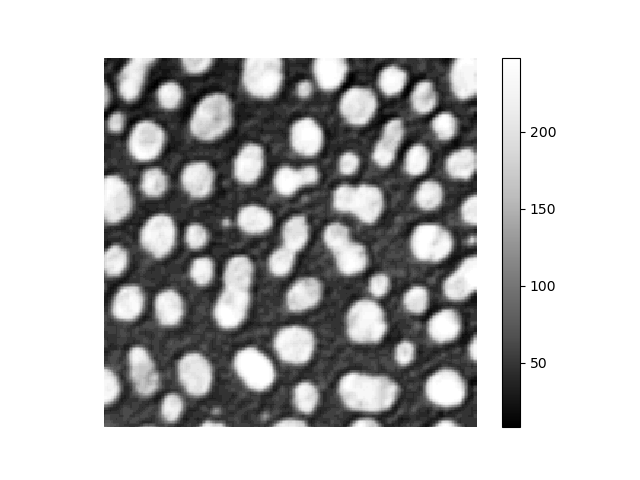
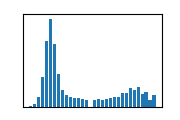

In [3]:
image = imread("data/blobs.tif")
stackview.insight(image)

This is the prompt we submit to the server.

In [4]:
my_prompt = """
Analyse the following image by counting the bright blobs. Respond with the number only.
"""

prompt_with_image(my_prompt, image)

'56'

## Benchmarking vision-LLMs
We can run this prompt in a loop for a couple of vision models.

In [5]:
num_samples = 25

models = {
    "gpt-4-turbo-2024-04-09":[],    
    "gpt-4o-2024-05-13":[],
    "gpt-4o-2024-08-06":[],
    "gpt-4o-2024-11-20":[],
}
for model in models.keys():
    samples = []

    while len(samples) < num_samples:
        result = prompt_with_image(my_prompt, image, model)

        try:
            samples.append(int(result))
        except:
            print("Error processing result:", result)
    
    models[model] = samples

sampled_models = pd.DataFrame(models)

Let's get an overview about samples:

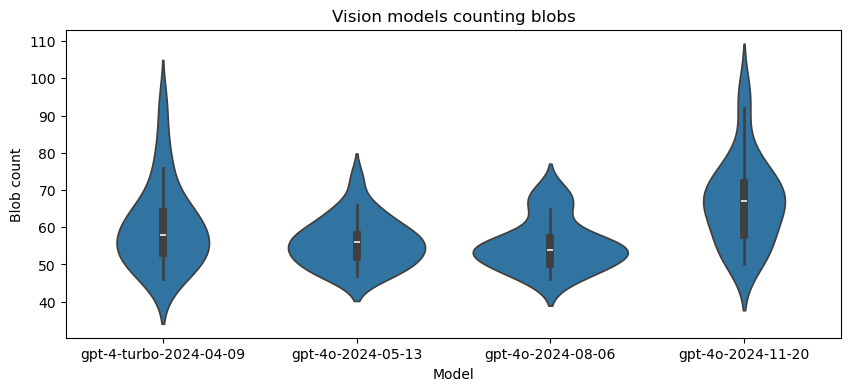

In [6]:
# Extract the two columns for comparison
columns_to_plot = sampled_models[models.keys()]

# Melt the dataframe to prepare for plotting
df_melted = columns_to_plot.melt(var_name='Model', value_name='Blob count')

# Draw the violin plot
plt.figure(figsize=(10, 4))
sns.violinplot(x='Model', y='Blob count', data=df_melted)
plt.title('Vision models counting blobs')
plt.show()

These are the results in detail:

In [7]:
sampled_models

,gpt-4-turbo-2024-04-09,gpt-4o-2024-05-13,gpt-4o-2024-08-06,gpt-4o-2024-11-20
0,93,56,55,67
1,61,52,55,73
2,54,62,53,50
3,49,53,70,72
4,68,73,57,74
5,53,58,50,53
6,54,52,56,67
7,64,56,68,68
8,61,47,50,52
9,51,54,53,61


In [8]:
sampled_models.describe()

,gpt-4-turbo-2024-04-09,gpt-4o-2024-05-13,gpt-4o-2024-08-06,gpt-4o-2024-11-20
count,25.000000,25.000000,25.000000,25.000000
mean,60.240000,55.880000,55.360000,66.920000
std,11.369843,6.489222,6.726069,11.718646
min,46.000000,47.000000,46.000000,50.000000
25%,53.000000,52.000000,50.000000,58.000000
50%,58.000000,56.000000,54.000000,67.000000
75%,64.000000,58.000000,57.000000,72.000000
max,93.000000,73.000000,70.000000,97.000000


In [9]:
sampled_models.to_csv("blob_count_by_llms.csv")